# SLC inhibitor predictions

We compare a list of SLC inhibitors from the GSF lab with a background set from ChEMBL

36
(3624, 32)
(5593, 32)


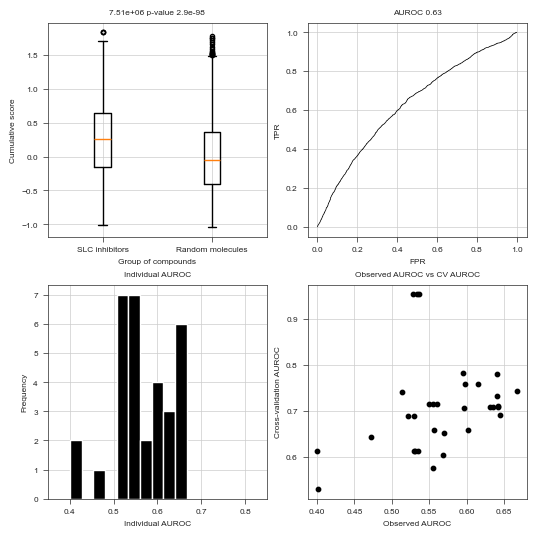

In [20]:
import pandas as pd
import joblib
import stylia
import numpy as np
from scipy.stats import mannwhitneyu
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import PowerTransformer as Scaler

MIN_AUROC = 0.0
MAX_MW = 500
MIN_MW = 50

df_bg = pd.read_csv("../results/2_chembl_predictions_groups.tsv", sep="\t")
df_in = pd.read_csv("../results/2_gsf_predictions_groups.tsv", sep="\t")

df_in = df_in[df_in["mw"] < MAX_MW]
df_bg = df_bg[df_bg["mw"] < MAX_MW]
df_in = df_in[df_in["mw"] > MIN_MW]
df_bg = df_bg[df_bg["mw"] > MIN_MW]

metadata = joblib.load("../results/1_experimental_validation_predictions_groups.metadata")

MIN_AUROC = 0.5

slc_columns = list([x for x in df_in.columns if x.startswith("clu") or x.startswith("prot")])
print(len(slc_columns))

idxs = []
aurocs = []
for j in range(len(slc_columns)):
    auroc = metadata[j]["auroc"]
    if auroc is None:
        continue
    if auroc[0] > MIN_AUROC:
        idxs += [j]
        aurocs += [auroc[0]]

cv_aurocs = [x for x in aurocs]

weights = np.clip(aurocs, 0.5, 1) - 0.5
weights = weights / np.sum(weights)

X_in = np.array(df_in[slc_columns])[:,idxs]
X_bg = np.array(df_bg[slc_columns])[:,idxs]
scaler = Scaler().fit(X_bg)
X_bg = scaler.transform(X_bg)
X_in = scaler.transform(X_in)

print(X_in.shape)
print(X_bg.shape)

vals_in = np.average(X_in, axis=1, weights=weights)
vals_bg = np.average(X_bg, axis=1, weights=weights)

fig, axs = stylia.create_figure(2,2,width=stylia.TWO_COLUMNS_WIDTH*0.75, height=stylia.TWO_COLUMNS_WIDTH*0.75)
ax = axs.next()

ax.boxplot([vals_in, vals_bg], flierprops=dict(marker='o', markersize=3))
ax.set_xticklabels(["SLC inhibitors", "Random molecules"])
u_statistic, p_value = mannwhitneyu(vals_bg, vals_in)
stylia.label(ax=ax, title="{0:.3g} p-value {1:.2g}".format(u_statistic, p_value), xlabel="Group of compounds", ylabel="Cumulative score")

ax = axs.next()
fpr, tpr, _ = roc_curve([1]*len(vals_in) + [0]*len(vals_bg), list(vals_in) + list(vals_bg))
ax.plot(fpr, tpr, color="black")
stylia.label(ax=ax, title="AUROC {0:.2f}".format(auc(fpr, tpr)), xlabel="FPR", ylabel="TPR")

ax = axs.next()
aurocs = []
for i in range(X_in.shape[1]):
    v1 = X_in[:, i]
    v0 = X_bg[:, i]
    fpr, tpr, _ = roc_curve([1]*len(v1) + [0]*len(v0), list(v1) + list(v0))
    aurocs += [auc(fpr, tpr)]
ax.hist(aurocs, bins=10, color="black")
ax.set_xlim(0.35, 0.85)
ax.plot([0,0], [1,1], color="black", linestyle="--")
stylia.label(ax=ax, title="Individual AUROC", xlabel="Individual AUROC", ylabel="Frequency")

ax = axs.next()

ax.scatter(aurocs, cv_aurocs, color="black")
stylia.label(ax=ax, title="Observed AUROC vs CV AUROC", xlabel="Observed AUROC", ylabel="Cross-validation AUROC")

stylia.save_figure("../assets/gsf_validation_exploratory_groups.png")